In this notebook we provide example code to compute geodesics in both Boyer-linquist time $t$ and Mino time $\lambda$.

In [1]:
# include("dependencies.jl");
include("../ConstantsOfMotion.jl");
include("../HughesOrbitalConstants.jl");
include("../InclinationMappings.jl");
include("../Kerr.jl");
include("../BLTimeGeodesics.jl");
include("../MinoTimeGeodesics.jl");

In [2]:
using .BLTimeGeodesics
using .MinoTimeGeodesics
using .ConstantsOfMotion
using .InclinationMappings
using .HughesOrbitalConstants
using Plots
using LaTeXStrings
using BenchmarkTools
using StaticArrays

In [3]:
# we list the geodesic parameters here in order to avoid two parameter files in this folder

a = 0.98;                                   # spin
p = 7.0;                                    # semi-latus rectum
e = 0.6;                                    # eccentricity

# specify your favourite inclination angle (in degrees)!
iota = true;                                # use iota
inferior_english_I = !iota;                 # use I (which is less pretty than the letter ι)
inclination = 57.39;

sign_Lz = inclination < 90.0 ? 1 : -1;      # prograde versus retrograde orbit

# geodesic solver parameters
nPoints = 1000;
t_max = 2000.0;                             # evolution time, t, in units of M
Δti = 0.1;                                  # initial time step in ODE solver

λ_max = 20.0;                               # evolution time, λ, in units of M
Δλi = 0.001;                                # initial time step in ODE solver

reltol =  1e-14;                            # relative tolerance
abstol =  1e-14;                            # absolute tolerance

specify_params = false;                     # specify parameters in the geodesic equation function (see ``BLTimeGeodesics.jl`` documentation)

data_path= "Data/";
mkpath(data_path);

# Converting between orbital parameterizations

Above, you specified your favourite inclination angle. We must now convert it to θmin, since this is what all the internal functions written in this package use.

In [4]:
if iota
    θmin = InclinationMappings.iota_to_theta_min(a, p, e, inclination)
    println("ι = $(inclination) degrees => θmin = $(θmin) radians")
else
    θmin = InclinationMappings.I_to_theta_min(inclination, sign_Lz)
    println("I = $(inclination) degrees => θmin = $(θmin) radians ")
end

ι = 57.39 degrees => θmin = 0.5709042769314503 radians


We can also convert between orbital parameterizations $(E, L, Q, C) \leftrightarrow (p, e, θ_{\mathrm{min}})$. Note that $C$ corresponds to the Carter constant of the orbit usually denoted by '$Q$' elsewhere, while $Q$ is an alternative definition of the Carter constant (see Eqs. 16-17 of arXiv:2401.09577v2)

In [5]:
E, L, Q, C = ConstantsOfMotion.compute_ELC(a, p, e, θmin, sign_Lz)

(0.9575511133867706, 1.7347613135505888, 7.986574698741883, 7.3523835021492046)

And we can check that going back to $(p, e, \theta_{\mathrm{min}})$ gives the same result

In [6]:
p2, e2, θmin2 = ConstantsOfMotion.compute_p_e_θmin(a, E, L, Q, C)
println(isapprox(p, p2) && isapprox(e, e2) && isapprox(θmin, θmin2))

true


The previous two functions use the method described in App. E of arXiv:2401.09577v2 for the mapping between orbital parameterizations. We can also use the method outlined in the more recent arXiv:2401.09577v2 to perform the mapping $(E, L, Q, C)\to(p, e, \theta_{\mathrm{min}})$, where we have diverted from the notation used in the reference and instead use $(E, L, Q, C)$ as input in order to be consistent with the rest of this package.

In [7]:
p3, e3, θmin3 = HughesOrbitalConstants.compute_p_e_θmin(a, E, L, Q, C)
println(isapprox(p, p3) && isapprox(e, e3) && isapprox(θmin, θmin3))

true


Finally, we can also compute the fundamental frequencies in either Boyer-Lindquist time or Mino time

In [8]:
mino_freqs = ConstantsOfMotion.KerrFreqs(a, p, e, θmin, sign_Lz)    # outputs [ωr, ωθ, ωφ, ωt]

4-element Vector{Float64}:
   2.109803649555045
   3.2181992567642337
   3.5568844355072446
 106.63216519221317

In [9]:
BL_freqs = mino_freqs[1:3] / mino_freqs[4]    # computes [Ωr, Ωθ, Ωϕ]

3-element Vector{Float64}:
 0.019785808960663533
 0.030180379915977204
 0.033356580813075215

# Geodesics in Boyer-Lindquist Time

### Future directed geodesics

In [10]:
# compute geodesic
@time BLTimeGeodesics.compute_kerr_geodesic(a, p, e, θmin, sign_Lz, nPoints, specify_params, t_max, Δti, reltol, abstol, data_path=data_path, save_to_file=true)

File created: Data/Kerr_geo_sol_a_0.98_p_7.0_e_0.6_θmin_0.571_prograde_nPoints_1000_T_2000.0_rtol_1.0e-14_atol_1.0e-14.h5
  7.966673 seconds (5.29 M allocations: 342.335 MiB, 3.42% gc time, 99.60% compilation time: <1% of which was recompilation)


In [11]:
# load geodesic trajectory t, r, θ, ϕ from file
t, r, theta, phi = BLTimeGeodesics.load_kerr_geodesic_trajectory(a, p, e, θmin, sign_Lz, nPoints, t_max, reltol, abstol, data_path);

In [12]:
# plot vertical lines for multiples of the BL frequencies
integers = [1, 2, 3, 4, 5, 5, 6, 7, 8, 9, 10];
kTimesOmegaR = @. integers * 2π / BL_freqs[1];
kTimesOmegaTheta = @. integers * 2π / BL_freqs[2];
kTimesOmegaPhi = @. integers * 2π / BL_freqs[3];

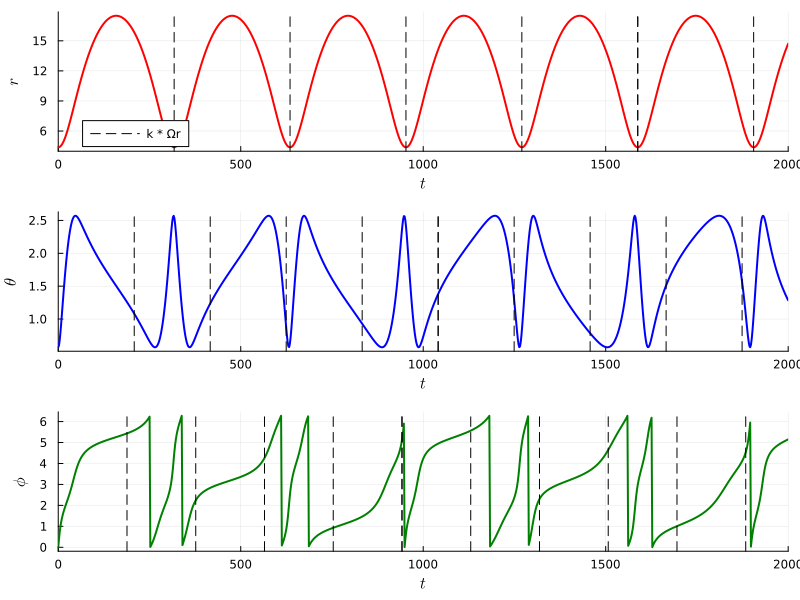

In [13]:

plot1 = plot(t, r, linewidth=2.0, xlabel = L"t", ylabel = L"r", color=:red, label="", legend=true, xlims=(0, t_max))
vline!(plot1, kTimesOmegaR, color=:black, linestyle=:dash, label="k * Ωr")
plot2 = plot(t, theta, linewidth=2.0, xlabel = L"t", ylabel = L"\theta", color=:blue, legend=false, xlims=(0, t_max))
vline!(plot2, kTimesOmegaTheta, color=:black, linestyle=:dash, label="k * Ωθ")
plot3 = plot(t, mod.(phi, 2π), linewidth=2.0, xlabel = L"t", ylabel = L"\phi", color=:green, legend=false, xlims=(0, t_max))
vline!(plot3, kTimesOmegaPhi, color=:black, linestyle=:dash, label="k * Ωφ")
plot(plot1, plot2, plot3, layout=(3,1), size=(800, 600))

One can also load the full solution, which contains the coordinates, their first and second derivatives, the relativistic gamma factor and the angle variables $\psi, \chi$ via

In [14]:
t, r, θ, ϕ, r_dot, θ_dot, ϕ_dot, r_ddot, θ_ddot, ϕ_ddot, dt_dτ, psi, chi = BLTimeGeodesics.load_full_kerr_geodesic(a, p, e, θmin, sign_Lz, nPoints, t_max, reltol, abstol, data_path);

Alternatively, one can also not save the result to file

In [15]:
@time t, r, θ, ϕ, r_dot, θ_dot, ϕ_dot, r_ddot, θ_ddot, ϕ_ddot, dt_dτ, psi, chi =  BLTimeGeodesics.compute_kerr_geodesic(a, p, e, θmin, sign_Lz, nPoints, specify_params, t_max, Δti, reltol, abstol, data_path=data_path, save_to_file=false);

  0.054380 seconds (239.71 k allocations: 8.071 MiB, 55.13% gc time, 8.71% compilation time)


### Past directed geodesics

We also provide functions which allows one to compute past-directed geodesics:

In [16]:
@time t_p, r_p, θ_p, ϕ_p, r_dot_p, θ_dot_p, ϕ_dot_p, r_ddot_p, θ_ddot_p, ϕ_ddot_p, dt_dτ_p, psi_p, chi_p =  BLTimeGeodesics.compute_kerr_geodesic_past(a, p, e, θmin, sign_Lz, nPoints, specify_params, t_max, Δti, reltol, abstol, data_path=data_path, save_to_file=false);

  1.784052 seconds (1.48 M allocations: 94.008 MiB, 3.29% gc time, 99.18% compilation time)


In [17]:
tt_p, rr_p, θθ_p, φφ_p, rr_dot_p, θθ_dot_p, ϕϕ_dot_p, rr_ddot_p, θθ_ddot_p, ϕϕ_ddot_p, dt_dττ_p, ppsi_p, cchi_p  = BLTimeGeodesics.compute_kerr_geodesic_past(a, p, e, θmin, sign_Lz, nPoints, specify_params, t_max, Δti, reltol, abstol, save_to_file=false);

### Past and future directed geodesics

Given some set of initial angle variables $(\psi,\chi, \phi)$, we can then compute a geodesic which extends into to the future t = t_max / 2 and into the past with t = - t_max / 2: 

In [18]:
ics = @SArray [psi[1], chi[1], phi[1]];

In [19]:
t_fp, r_fp, θ_fp, ϕ_fp, r_dot_fp, θ_dot_fp, ϕ_dot_fp, r_ddot_fp, θ_ddot_fp, ϕ_ddot_fp, dt_dτ_fp, psi_fp, chi_fp = BLTimeGeodesics.compute_kerr_geodesic_past_and_future(a, p, e, θmin, sign_Lz, specify_params, 2 * nPoints - 1,
                                                                                                                    2 * t_max, Δti, reltol, abstol, ics=ics, data_path=data_path, save_to_file=false);

In [20]:
# check for equality if we construct this future and past trajectory from the data computed above
nPointsPast = nPoints÷2;
nPointsFuture = nPoints - nPointsPast;

# check for equality
t_fp_1 = [t_p[1:end-1]; t]; r_fp_1 = [r_p[1:end-1]; r]; θ_fp_1 = [θ_p[1:end-1]; θ]; ϕ_fp_1 = [ϕ_p[1:end-1]; ϕ];
r_dot_fp_1 = [r_dot_p[1:end-1]; r_dot]; θ_dot_fp_1 = [θ_dot_p[1:end-1]; θ_dot]; ϕ_dot_fp_1 = [ϕ_dot_p[1:end-1]; ϕ_dot];
r_ddot_fp_1 = [r_ddot_p[1:end-1]; r_ddot]; θ_ddot_fp_1 = [θ_ddot_p[1:end-1]; θ_ddot]; ϕ_ddot_fp_1 = [ϕ_ddot_p[1:end-1]; ϕ_ddot];
dt_dτ_fp_1 = [dt_dτ_p[1:end-1]; dt_dτ]; psi_fp_1 = [psi_p[1:end-1]; psi]; chi_fp_1 = [chi_p[1:end-1]; chi];

println(isequal(t_fp_1, t_fp) && isequal(r_fp_1, r_fp) && isequal(θ_fp_1, θ_fp) && isequal(ϕ_fp_1, ϕ_fp) && isequal(r_dot_fp_1, r_dot_fp) && isequal(θ_dot_fp_1, θ_dot_fp) &&
isequal(ϕ_dot_fp_1, ϕ_dot_fp) && isequal(r_ddot_fp_1, r_ddot_fp) && isequal(θ_ddot_fp_1, θ_ddot_fp) && isequal(ϕ_ddot_fp_1, ϕ_ddot_fp) && isequal(dt_dτ_fp_1, dt_dτ_fp) &&
isequal(psi_fp_1, psi_fp) && isequal(chi_fp_1, chi_fp))

true


# Geodesics in Mino time

### Future directed geodesics

In [21]:
# compute geodesic
@time MinoTimeGeodesics.compute_kerr_geodesic(a, p, e, θmin, sign_Lz, nPoints, specify_params, λ_max, Δλi, reltol, abstol, data_path=data_path, save_to_file=true)

File created: Data/Kerr_geo_Mino_sol_a_0.98_p_7.0_e_0.6_θmin_0.571_prograde_nPoints_1000_Λ_20.0_rtol_1.0e-14_atol_1.0e-14.h5
  2.759060 seconds (2.27 M allocations: 146.157 MiB, 4.94% gc time, 99.43% compilation time)


In [22]:
# load geodesic trajectory t, r, θ, ϕ from file
λ, r, theta, phi = MinoTimeGeodesics.load_kerr_geodesic_trajectory(a, p, e, θmin, sign_Lz, nPoints, λ_max, reltol, abstol, data_path);

In [23]:
# plot vertical lines for multiples of the BL frequencies
integers = [1, 2, 3, 4, 5, 5, 6, 7, 8, 9, 10];
kTimesomegaR = @. integers * 2π / mino_freqs[1];
kTimesomegaTheta = @. integers * 2π / mino_freqs[2];
kTimesomegaPhi = @. integers * 2π / mino_freqs[3];

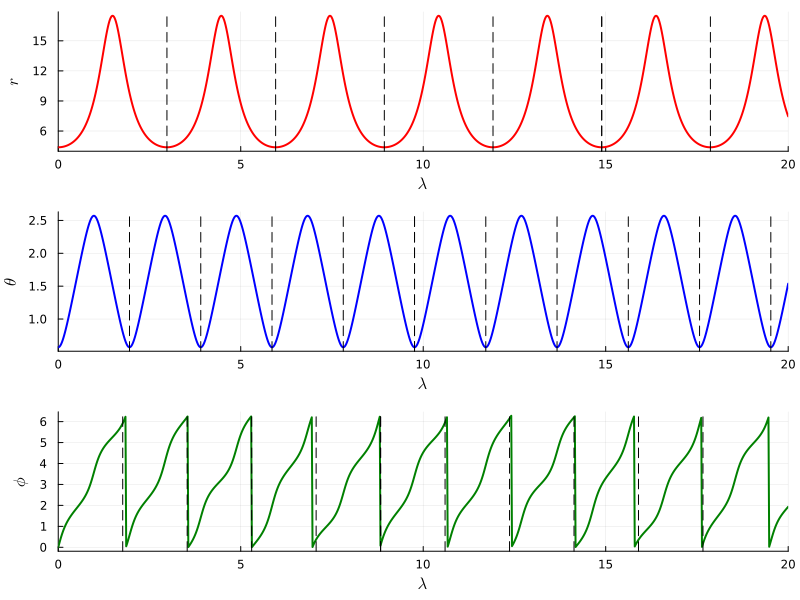

In [24]:
plot1 = plot(λ, r, linewidth=2.0, xlabel = L"\lambda", ylabel = L"r", color=:red, legend=false, xlims=(0, λ_max))
vline!(plot1, kTimesomegaR, color=:black, linestyle=:dash, label="k * ωr")
plot2 = plot(λ, theta, linewidth=2.0, xlabel = L"\lambda", ylabel = L"\theta", color=:blue, legend=false, xlims=(0, λ_max))
vline!(plot2, kTimesomegaTheta, color=:black, linestyle=:dash, label="k * ωθ")
plot3 = plot(λ, mod.(phi, 2π), linewidth=2.0, xlabel = L"\lambda", ylabel = L"\phi", color=:green, legend=false, xlims=(0, λ_max))
vline!(plot3, kTimesomegaPhi, color=:black, linestyle=:dash, label="k * ωϕ")
plot(plot1, plot2, plot3, layout=(3,1), size=(800, 600))

One can also load the full solution, which contains the coordinates, their first and second derivatives, the relativistic gamma factor and the angle variables $\psi, \chi$ via

In [25]:
λ, t, r, θ, ϕ, r_dot, θ_dot, ϕ_dot, r_ddot, θ_ddot, ϕ_ddot, dt_dτ, psi, chi = MinoTimeGeodesics.load_full_kerr_geodesic(a, p, e, θmin, sign_Lz, nPoints, λ_max, reltol, abstol, data_path);

Alternatively, one can also not save the result to file

In [26]:
@time λ, t, r, θ, ϕ, r_dot, θ_dot, ϕ_dot, r_ddot, θ_ddot, ϕ_ddot, dt_dτ, psi, chi =  MinoTimeGeodesics.compute_kerr_geodesic(a, p, e, θmin, sign_Lz, nPoints, specify_params, λ_max, Δλi, reltol, abstol, data_path=data_path, save_to_file=false);

  0.010615 seconds (62.17 k allocations: 1.258 MiB)


### Past directed geodesics

We also provide functions which allows one to compute past-directed geodesics:

In [27]:
include("../MinoTimeGeodesics.jl")
using .MinoTimeGeodesics

In [28]:
@time λ_p, t_p, r_p, θ_p, ϕ_p, r_dot_p, θ_dot_p, ϕ_dot_p, r_ddot_p, θ_ddot_p, ϕ_ddot_p, dt_dτ_p, psi_p, chi_p =  MinoTimeGeodesics.compute_kerr_geodesic_past(a, p, e, θmin, sign_Lz, nPoints, specify_params, λ_max, Δλi, reltol, abstol, data_path=data_path, save_to_file=false);

  1.952621 seconds (1.56 M allocations: 98.054 MiB, 3.62% gc time, 99.24% compilation time)


### Past and future directed geodesics

Given some set of initial angle variables $(\psi,\chi, \phi)$, we can then compute a geodesic which extends into to the future λ = λ_max / 2 and into the past with λ = - λ_max / 2: 

In [29]:
ics = @SArray [t[1], psi[1], chi[1], phi[1]];

In [30]:
λ_fp, t_fp, r_fp, θ_fp, ϕ_fp, r_dot_fp, θ_dot_fp, ϕ_dot_fp, r_ddot_fp, θ_ddot_fp, ϕ_ddot_fp, dt_dτ_fp, psi_fp, chi_fp = MinoTimeGeodesics.compute_kerr_geodesic_past_and_future(a, p, e, θmin, sign_Lz, specify_params, 2 * nPoints - 1,
                                                                                                                    2 * λ_max, Δλi, reltol, abstol, ics=ics, data_path=data_path, save_to_file=false);

In [31]:
# check for equality if we construct this future and past trajectory from the data computed above
nPointsPast = nPoints÷2;
nPointsFuture = nPoints - nPointsPast;

# check for equality
t_fp_1 = [t_p[1:end-1]; t]; r_fp_1 = [r_p[1:end-1]; r]; θ_fp_1 = [θ_p[1:end-1]; θ]; ϕ_fp_1 = [ϕ_p[1:end-1]; ϕ];
r_dot_fp_1 = [r_dot_p[1:end-1]; r_dot]; θ_dot_fp_1 = [θ_dot_p[1:end-1]; θ_dot]; ϕ_dot_fp_1 = [ϕ_dot_p[1:end-1]; ϕ_dot];
r_ddot_fp_1 = [r_ddot_p[1:end-1]; r_ddot]; θ_ddot_fp_1 = [θ_ddot_p[1:end-1]; θ_ddot]; ϕ_ddot_fp_1 = [ϕ_ddot_p[1:end-1]; ϕ_ddot];
dt_dτ_fp_1 = [dt_dτ_p[1:end-1]; dt_dτ]; psi_fp_1 = [psi_p[1:end-1]; psi]; chi_fp_1 = [chi_p[1:end-1]; chi];

println(isequal(t_fp_1, t_fp) && isequal(r_fp_1, r_fp) && isequal(θ_fp_1, θ_fp) && isequal(ϕ_fp_1, ϕ_fp) && isequal(r_dot_fp_1, r_dot_fp) && isequal(θ_dot_fp_1, θ_dot_fp) &&
isequal(ϕ_dot_fp_1, ϕ_dot_fp) && isequal(r_ddot_fp_1, r_ddot_fp) && isequal(θ_ddot_fp_1, θ_ddot_fp) && isequal(ϕ_ddot_fp_1, ϕ_ddot_fp) && isequal(dt_dτ_fp_1, dt_dτ_fp) &&
isequal(psi_fp_1, psi_fp) && isequal(chi_fp_1, chi_fp))

true
